## Pré-processamento

Neste notebook iremos preparar/gerar os dados de entrada para nossa rede. A base de dados utilizada pode ser encontrada [aqui](https://talhassner.github.io/home/projects/Adience/Adience-data.html). 

![alt text](images/photos.png "Fotos")

Após extrair as pastas você deverá ver as seguintes subpasta e arquivos:
 
    aligned/
    fold_0_data.txt
    fold_1_data.txt
    fold_2_data.txt
    fold_3_data.txt
    fold_4_data.txt
    fold_frontal_0_data.txt
    fold_frontal_1_data.txt
    fold_frontal_2_data.txt
    fold_frontal_3_data.txt
    fold_frontal_4_data.txt

### Informações sobre a base de dados

- Total de fotos: 26580
- Número de intervalos de idade / intervalos: 8 (0-2, 4-6, 8-13, 15-20, 25-32, 38-43, 48-53, 60-100)
- Gênero: M/F

## Dependências

In [1]:
import numpy as np  # manipular vetores
import pandas as pd # manipular arquivos txt
import pickle as pkl # comprimir/serializar vetores
from PIL import Image # maior eficiência ao processar as imagens
import matplotlib.pyplot as plt  # plotar imagens

## Arquivos de entrada

A principal diferença entre fold e fold_frontal é o ângulo de inclinação da face. No frontal não existe imagem com a face inclinida, já no normal considera todas as imagens do banco.

In [2]:
fold = ['fold_%d_data.txt' % i for i in range(5)]

In [3]:
def save(obj,name):
    ''' Função para salvar objeto '''
    with open(name+'.pkl', 'wb') as f:
        pkl.dump(obj, f, pkl.HIGHEST_PROTOCOL)

def load(name):
    ''' Função para carregar objeto serializado '''
    with open(name+'.pkl', 'rb') as f:
        return pkl.load(f)

## thanks https://github.com/mari-linhares/tensorflow-brasil
def show(num_dados):
    print('Exemplos de %d imagens da base de treino' % num_dados)
    
    # Escolhemos índices aleatórios
    random_indices = np.random.randint(0, data['imagens'].shape[0], num_dados)
    
    # Buscando imagens e labels
    imagens = data['imagens'][random_indices]
    labels = data['labels'][random_indices]
    
    # Plottando imagens
    for index, (img, label) in enumerate(zip(imagens, labels)):
        plt.subplot(2, num_dados, index + 1)
        plt.axis('off')
        plt.imshow(img, cmap=plt.cm.gray_r, interpolation='nearest')
        plt.title('%i' % label)
    plt.show()

## Tratamento dados de gênero

Vamos verificar quais imagens estão com gênero indefinido e remover da nossa base de dados.

### Imagem inclinada

Para os arquivos que possuem **fiducial_yaw_angle** diferente de 0, iremos considerar o intervalo entre os ângulos de -45° e 45°.

In [4]:
for f in fold:
    df = pd.read_csv('data/'+f, sep="\t")
    
    for index, row in df.iterrows():
        genero = row['gender']
        angulo = row['fiducial_yaw_angle']
        
        if (genero!='m' and genero!='f') or (angulo >= 45 or angulo <= -45):
            df.drop(index, inplace=True)

    df.to_csv('txt/gender/'+f, index=False)

### Salvando arquivo

Iremos transforma nossas imagens (considerando apenas as que foram tratadas acima) em arrays numpy e fazer a seguinte conversão: 0 - Masculino (m) e 1 - Feminino 

In [5]:
WIDTH = HEIGHT = 256
MASCULINO = 0
FEMININO = 1

In [6]:
def serializer():
    ''' Salvar em arquivo com imagens (formato array numpy) e suas respectivas labels '''
    i = 0
    for f in fold:
        df = pd.read_csv('txt/gender/'+f, sep=",")
        imagens = []
        labels = []
        #--
        for index, row in df.iterrows():
            user_id = row['user_id']
            original_image = row['original_image']
            face_id = row['face_id']
            genero = MASCULINO if row['gender'] == 'm' else FEMININO
            # leitura da imagem
            image = Image.open('data/aligned/'+user_id+'/landmark_aligned_face.'+str(face_id)+'.'+original_image)
            # redimensiona imagem
            image = image.resize((WIDTH, HEIGHT), Image.LANCZOS)
            image = image.crop((14, 14, 241, 241))
            # transforma em array numpy
            imagens.append(np.array(image))
            labels.append(np.array(genero))
        # save dictionary
        obj = { 'imagens': np.array(imagens), 'labels': np.array(labels) }
        save(obj, 'serializer/gender/data_'+str(i))
        i += 1
serializer()

### Carregando arquivo

Após manipular ou modificar os dados é sempre importante garantir que os dados estão no formato esperado e não foram corrompidos ou alterados indevidamente.

In [7]:
# Escolhendo um arquivo aleatorio
data = load('serializer/gender/data_%d' % np.random.randint(5))
data['imagens'].shape, data['labels'].shape

((3818, 227, 227, 3), (3818,))

Exemplos de 5 imagens da base de treino


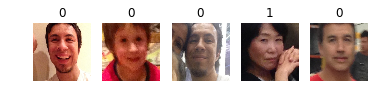

In [8]:
show(5)

## Tratamento dados de idade

Vamos verificar quais imagens estão com intervalos de idade indefinido e remover da nossa base de dados. Além disso vamos separar imagens por gênero.

In [4]:
AGE_RANGE = ['(0, 2)', 
             '(4, 6)', 
             '(8, 13)', 
             '(15, 20)', 
             '(25, 32)', 
             '(38, 43)', 
             '(48, 53)', 
             '(60, 100)']

In [5]:
def fmt1(idade):
    ''' Formata um valor inteiro em um intervalo de idade válido '''
    idade = int(idade)
    if idade >= 0 and idade <= 2:
        return '(0, 2)'
    elif idade >= 4 and idade <= 6:
        return '(4, 6)'
    elif idade >= 8 and idade <= 13:
        return '(8, 13)'
    elif idade >= 15 and idade <= 20:
        return '(15, 20)'
    elif idade >= 25 and idade <= 32:
        return '(25, 32)'
    elif idade >= 38 and idade <= 43:
        return '(38, 43)'
    elif idade >= 48 and idade <= 53:
        return '(48, 53)'
    elif idade >= 60 and idade <= 100:
        return '(60, 100)'
    else:
        return None

In [6]:
def fmt2(idade):
    ''' Formata intervalo indefinido para um intervalo de idade válido '''
    if idade=='(8, 12)':
        return '(8, 13)'
    elif idade=='(38, 42)':
        return '(38, 43)'
    elif idade=='(27, 32)':
        return '(25, 32)'
    else:
        return None

In [7]:
def wrapper_fmt(idade):
    return fmt1(idade) if len(idade) < 3 else fmt2(idade)

In [8]:
def categorical_fmt(idade_range):
    if idade_range=='(0, 2)':
        return 0
    elif idade_range=='(4, 6)':
        return 1
    elif idade_range=='(8, 13)':
        return 2
    elif idade_range=='(15, 20)':
        return 3
    elif idade_range=='(25, 32)':
        return 4
    elif idade_range=='(38, 43)':
        return 5
    elif idade_range=='(48, 53)':
        return 6
    elif idade_range=='(60, 100)':
        return 7

### Imagem inclinada
Para os arquivos que possuem fiducial_yaw_angle diferente de 0, iremos considerar o intervalo entre os ângulos de -45° e 45°.

#### Todos gêneros

Primeiramente considerar todo tipo de gênero na nossa base (masculino/feminino/indefinido).

In [95]:
for f in fold:
    df = pd.read_csv('data/'+f, sep="\t")
    
    for index, row in df.iterrows():
        idade = row['age']
        angulo = row['fiducial_yaw_angle']
        idade = idade if idade in AGE_RANGE else wrapper_fmt(idade)
        
        if (idade is None) or (angulo >= 45 or angulo <= -45):
            df.drop(index, inplace=True)
        else:
            df.at[index, 'age'] = idade

    df.to_csv('txt/age/'+f, index=False)

#### Gênero Masculino

Vamos considerar agora só as imagens que possuem gênero definido como masculino.

In [96]:
for f in fold:
    df = pd.read_csv('data/'+f, sep="\t")
    
    for index, row in df.iterrows():
        idade = row['age']
        angulo = row['fiducial_yaw_angle']
        genero = row['gender']
        idade = idade if idade in AGE_RANGE else wrapper_fmt(idade)
       
        if (idade is None) or (angulo >= 45 or angulo <= -45) or (genero!='m'):
            df.drop(index, inplace=True)
        else:
            df.at[index, 'age'] = idade

    df.to_csv('txt/age-male/'+f, index=False)

#### Gênero Feminino

Vamos considerar agora só as imagens que possuem gênero definido como feminino.

In [9]:
for f in fold:
    df = pd.read_csv('data/'+f, sep="\t")
    
    for index, row in df.iterrows():
        idade = row['age']
        angulo = row['fiducial_yaw_angle']
        genero = row['gender']
        idade = idade if idade in AGE_RANGE else wrapper_fmt(idade)
        
        if (idade is None) or (angulo >= 45 or angulo <= -45) or (genero!='f'):
            df.drop(index, inplace=True)
        else:
            df.at[index, 'age'] = idade

    df.to_csv('txt/age-female/'+f, index=False)

### Salvando arquivo

Iremos transforma nossas imagens (considerando apenas as que foram tratadas acima) em arrays numpy e fazer a seguinte conversão: 1 - '0-2', 2 - '4-6, 3 - '8-13', 4 - '15-20', 5 - '25-32', 6 - '38-43', 7 - '48-53', 8 - '60-100'

In [10]:
WIDTH = HEIGHT = 256

In [11]:
def serializer(name):
    ''' Salvar em arquivo com imagens (formato array numpy) e suas respectivas labels '''
    i = 0
    for f in fold:
        imagens = []
        labels = []
        df = pd.read_csv('txt/'+name+f, sep=",")
        #--
        for index, row in df.iterrows():
            user_id = row['user_id']
            original_image = row['original_image']
            face_id = row['face_id']
            idade = categorical_fmt(row['age'])
            # leitura da imagem
            image = Image.open('data/aligned/'+user_id+'/landmark_aligned_face.'+str(face_id)+'.'+original_image)
            # redimensiona imagem
            image = image.resize((WIDTH, HEIGHT), Image.LANCZOS)
            image = image.crop((14, 14, 241, 241))
            # transforma em array numpy
            imagens.append(np.array(image))
            labels.append(np.array(idade))
        
        # save dictionary
        obj = { 'imagens': np.array(imagens), 'labels': np.array(labels) }
        save(obj, 'serializer/'+name+'data_'+str(i))
        i += 1

In [12]:
# todos os generos
serializer('age/')
# masculino
serializer('age-male/')
# feminino
serializer('age-female/')

### Carregando arquivo

Após manipular ou modificar os dados é sempre importante garantir que os dados estão no formato esperado e não foram corrompidos ou alterados indevidamente.

#### Todos gêneros

In [104]:
# Escolhendo um arquivo aleatorio
data = load('serializer/age/data_%d' % np.random.randint(5))
data['imagens'].shape, data['labels'].shape

((4174, 228, 228, 3), (4174,))

Exemplos de 5 imagens da base de treino


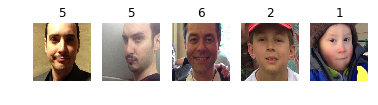

In [105]:
show(5)

#### Gênero Masculino

In [39]:
# Escolhendo um arquivo aleatorio
data = load('serializer/age-male/data_%d' % np.random.randint(5))
data['imagens'].shape, data['labels'].shape

((1278, 227, 227, 3), (1278,))

Exemplos de 5 imagens da base de treino


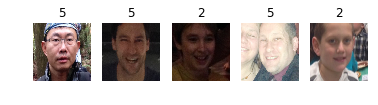

In [40]:
show(5)

#### Gênero Femino

In [125]:
# Escolhendo um arquivo aleatorio
data = load('serializer/age-female/data_%d' % np.random.randint(5))
data['imagens'].shape, data['labels'].shape

((1580, 228, 228, 3), (1580,))

Exemplos de 5 imagens da base de treino


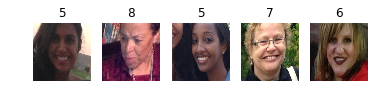

In [129]:
show(5)